<div align="center">
    <h1>Project MeDas</h1>
    <h3>Detection of COVID-19 using Machine Learning methods</h3>
    <p><b>Applied Data Science in Healthcare:</b> Prof. Dr. Christina Bartenschlager</p>
    <hr>
</div>

# Data Loading

In [ ]:
!python --version

Python 3.12.12


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_raw = pd.read_csv('/content/data.csv')

In [ ]:
df_raw = df_raw.drop(columns={"Suspect","Unnamed: 0"})



# Data Cleaning

In [ ]:
df_raw.head()

,Sex,Age,CA,CK,CREA,ALP,GGT,GLU,AST,ALT,...,LY,MO,EO,BA,NET,LYT,MOT,EOT,BAT,target
0,1,82,"2,09",NaN,"1,15",95,40,78,26,21,...,"13,4","9,5","2,9","0,5","6,4","1,2","0,8","0,3",0,0
1,1,51,"1,97",237,"0,97",54,98,98,74,84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1,58,"2,11",NaN,1,80,147,106,41,36,...,"11,2","7,3","0,3","0,1","5,45","0,75","0,5",0,0,0
3,0,82,"2,27",138,"0,755","123,5","176,5",106,114,63,...,"36,5","9,5","1,7","0,9","3,6","2,6","0,7","0,1","0,1",0
4,1,79,"2,07",73,"1,81",62,"36,5",96,28,"38,5",...,44,10,"8,5","0,5","0,4","0,5","0,1","0,1",0,0


## Checking Data Types

In [ ]:
df_raw.dtypes

,0
Sex,object
Age,object
CA,object
CK,object
CREA,object
ALP,object
GGT,object
GLU,object
AST,object
ALT,object


Most numerical variables are define as object, to work more efficiently we will transform them to int 32.

In [ ]:
num_cols = [
    "Age","CA","CK","CREA","ALP","GGT","GLU","AST","ALT","LDH","PCR",
    "KAL","NAT","UREA","WBC","RBC","HGB","HCT","MCV","MCH","MCHC",
    "PLT1","NE","LY","MO","EO","BA","NET","LYT","MOT","EOT","BAT"
]

# 1. Replace European commas with dots in all numeric columns
df_raw[num_cols] = df_raw[num_cols].replace(",", ".", regex=True)

# 2. Convert to numeric (float) and coerce errors
df_raw[num_cols] = df_raw[num_cols].apply(pd.to_numeric, errors="coerce")

# 3. Convert to float32 to save memory
df_raw[num_cols] = df_raw[num_cols].astype("float32")

# 4. Convert Sex and target to Int32 (allows NaN)
df_raw["Sex"] = pd.to_numeric(df_raw["Sex"], errors="coerce").astype("Int32")
df_raw["target"] = df_raw["target"].astype("Int32")

In [ ]:
df = df_raw.copy()


## Checking Duplicates

In [ ]:
df.duplicated().sum()

np.int64(9)

In [ ]:
df.drop_duplicates(inplace=True)
print("Duplicated rows removed. Verifying...")


Duplicated rows removed. Verifying...


In [ ]:
df.duplicated().sum()

np.int64(0)

All duplicated rows have been deleted.

## Detecting Outliers

In [ ]:
# Define the function to identify outliers using the Interquartile Range (IQR) method
def identify_outliers_iqr(df, column):
    """
    Identifies outliers in a numeric column based on the IQR criterion.

    Parameters:
    - df: pandas DataFrame.
    - column: Name of the column to analyze.

    Returns:
    - A dictionary containing outlier values grouped by the 'target' variable.
    """
    outliers = {}

    # Calculate quartiles and the Interquartile Range (IQR)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outlier values for each unique target class
    for target in df['target'].unique():
        outlier_values = df[
            (df['target'] == target) &
            ((df[column] < lower_bound) | (df[column] > upper_bound))
        ][column].tolist()
        outliers[target] = outlier_values

    return outliers

# Convert object columns to numeric types, replacing ',' with '.' for proper float conversion
for col in df.columns:
    if df[col].dtype == 'object' and col not in ['Patient', 'Sex']:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Initialize a list to store the summary results
results = []

# Apply outlier detection to each numeric column in the DataFrame
for column in df.columns:
    if column != 'target' and pd.api.types.is_numeric_dtype(df[column]):
        outliers = identify_outliers_iqr(df, column)
        for target in outliers:
            total_rows = len(df[df['target'] == target])
            num_outliers = len(outliers[target])
            # Calculate the outlier percentage per target class
            percentage_outliers = (num_outliers / total_rows) * 100 if total_rows > 0 else 0

            results.append({
                'Variable': column,
                'Target': target,
                'Outliers Count': num_outliers,
                'Percentage (%)': f"{percentage_outliers:.2f}"
            })

# Convert the results list into a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Configure pandas to display all rows without truncation
pd.set_option('display.max_rows', None)

# Display the final summary of detected outliers
print("Outliers detected using IQR method:")
print(results_df)

Outliers detected using IQR method:
   Variable  Target  Outliers Count Percentage (%)
0       Sex       0               0           0.00
1       Sex       1               0           0.00
2       Age       0              14           1.54
3       Age       1               2           0.25
4        CA       0              17           1.86
5        CA       1              11           1.35
6        CK       0              20           2.19
7        CK       1              58           7.12
8      CREA       0              85           9.32
9      CREA       1              62           7.61
10      ALP       0              70           7.68
11      ALP       1              31           3.80
12      GGT       0              49           5.37
13      GGT       1              72           8.83
14      GLU       0              52           5.70
15      GLU       1              83          10.18
16      AST       0              34           3.73
17      AST       1             105          1

## Detecting Missing Values

In [ ]:
missing_values = df.isna().sum()
percentage_missing = (df.isna().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage (%)': percentage_missing
})

missing_info = missing_info.sort_values(by='Percentage (%)', ascending=False)
print(missing_info)

        Missing Count  Percentage (%)
CK               1023       59.235669
UREA              667       38.621888
ALP               465       26.925304
GGT               427       24.724957
EO                353       20.440069
BA                353       20.440069
MOT               353       20.440069
NE                353       20.440069
EOT               353       20.440069
BAT               353       20.440069
MO                353       20.440069
LY                353       20.440069
NET               353       20.440069
LYT               353       20.440069
LDH               294       17.023741
GLU                89        5.153445
AST                89        5.153445
PCR                88        5.095541
ALT                87        5.037638
CA                 84        4.863926
KAL                71        4.111175
CREA               65        3.763752
NAT                64        3.705848
Age                54        3.126809
HGB                54        3.126809
WBC         

#Exploratory Data Analysis (EDA)

Now that data is transformed into the correct type, we will describe the data.

In [ ]:
df.describe()



,Sex,Age,CA,CK,CREA,ALP,GGT,GLU,AST,ALT,...,LY,MO,EO,BA,NET,LYT,MOT,EOT,BAT,target
count,1726.0,1673.000000,1643.000000,704.000000,1662.000000,1262.000000,1300.000000,1638.000000,1638.000000,1640.000000,...,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1727.0
mean,0.571842,60.949100,2.215060,181.643555,1.161565,88.538521,66.216957,119.035316,45.854328,39.174721,...,18.581280,7.832528,0.882217,0.339559,6.451065,1.367031,0.622232,0.066942,0.016278,0.471917
std,0.494955,19.543901,0.477238,405.712036,0.975984,71.441139,135.392090,57.910465,50.674011,42.548428,...,11.004689,3.882386,1.619529,0.271131,4.475700,0.952215,0.540846,0.144115,0.039668,0.499355
min,0.0,0.000000,1.363333,10.000000,0.190000,1.755000,4.000000,13.000000,7.000000,6.000000,...,1.200000,0.150000,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.0,48.000000,2.090000,53.000000,0.750000,56.500000,19.000000,91.000000,23.000000,18.000000,...,10.075000,5.400000,0.000000,0.200000,3.700000,0.800000,0.400000,0.000000,0.000000,0.0
50%,1.0,62.000000,2.200000,86.000000,0.940000,71.500000,34.000000,104.000000,32.000000,27.000000,...,16.600000,7.450000,0.200000,0.300000,5.300000,1.195000,0.500000,0.000000,0.000000,0.0
75%,1.0,77.000000,2.310000,161.250000,1.190000,94.000000,69.000000,125.000000,50.000000,44.000000,...,24.900000,9.700000,1.100000,0.450000,8.100000,1.700000,0.800000,0.100000,0.000000,1.0
max,1.0,100.000000,20.248707,7004.333496,15.700000,914.000000,3041.000000,855.000000,1018.500000,559.500000,...,67.000000,42.700001,12.700000,3.100000,73.000000,11.400000,14.500000,1.450000,0.700000,1.0


In [ ]:
df.shape

(1727, 34)

Our dataset contains 1736 rows and 36 columns.

### Relative Frequency of `Target` and `Sex` Variables

In [ ]:
df['target'].value_counts(normalize=True)

,proportion
target,
0,0.528083
1,0.471917


We can observe that the dataset is slightly unbalance, we will have to investigate if this will negatively affect the performance of our predective models.

## Univariate Analysis

###Demographic Variables

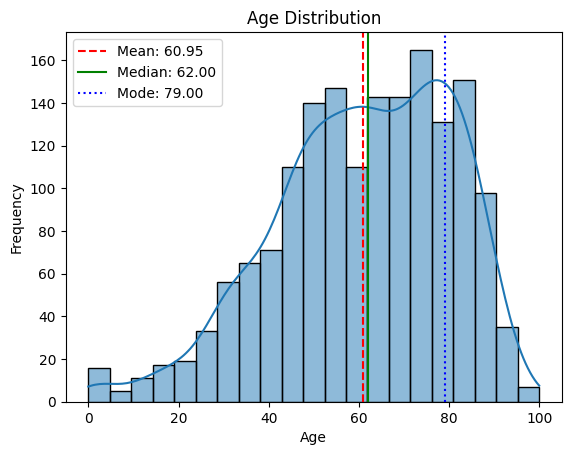

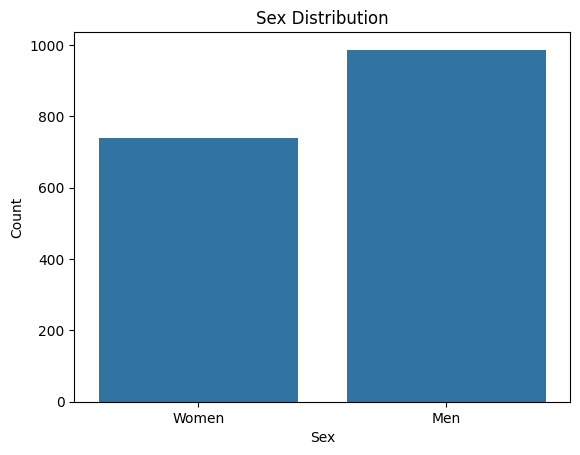

In [ ]:
from scipy import stats

# Age Distribution Plot
sns.histplot(x='Age', data=df, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Calculate mean, median, and mode for Age
age_data = df['Age'].dropna()
mean_age = age_data.mean()
median_age = age_data.median()
# sns.histplot automatically calculates bins, so mode can be approximated or found directly
mode_age = age_data.mode()[0] if not age_data.mode().empty else np.nan

# Add vertical lines for mean, median, and mode
plt.axvline(mean_age, color='r', linestyle='--', label=f'Mean: {mean_age:.2f}')
plt.axvline(median_age, color='g', linestyle='-', label=f'Median: {median_age:.2f}')
if not np.isnan(mode_age):
    plt.axvline(mode_age, color='b', linestyle=':', label=f'Mode: {mode_age:.2f}')
plt.legend()
plt.show()

# Sex Distribution Plot
sns.countplot(x='Sex', data=df)
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks([0, 1], ['Women', 'Men']) # Directly setting x-axis labels
plt.show()

We can observe that Age is left-skewed, indicating that most individuals in the dataset are older than the mean age of 60 years, while younger ages are less common.
Additionally, as mentioned previously, there is a larger proportion of men in the distribution.


###Biomarker Variables


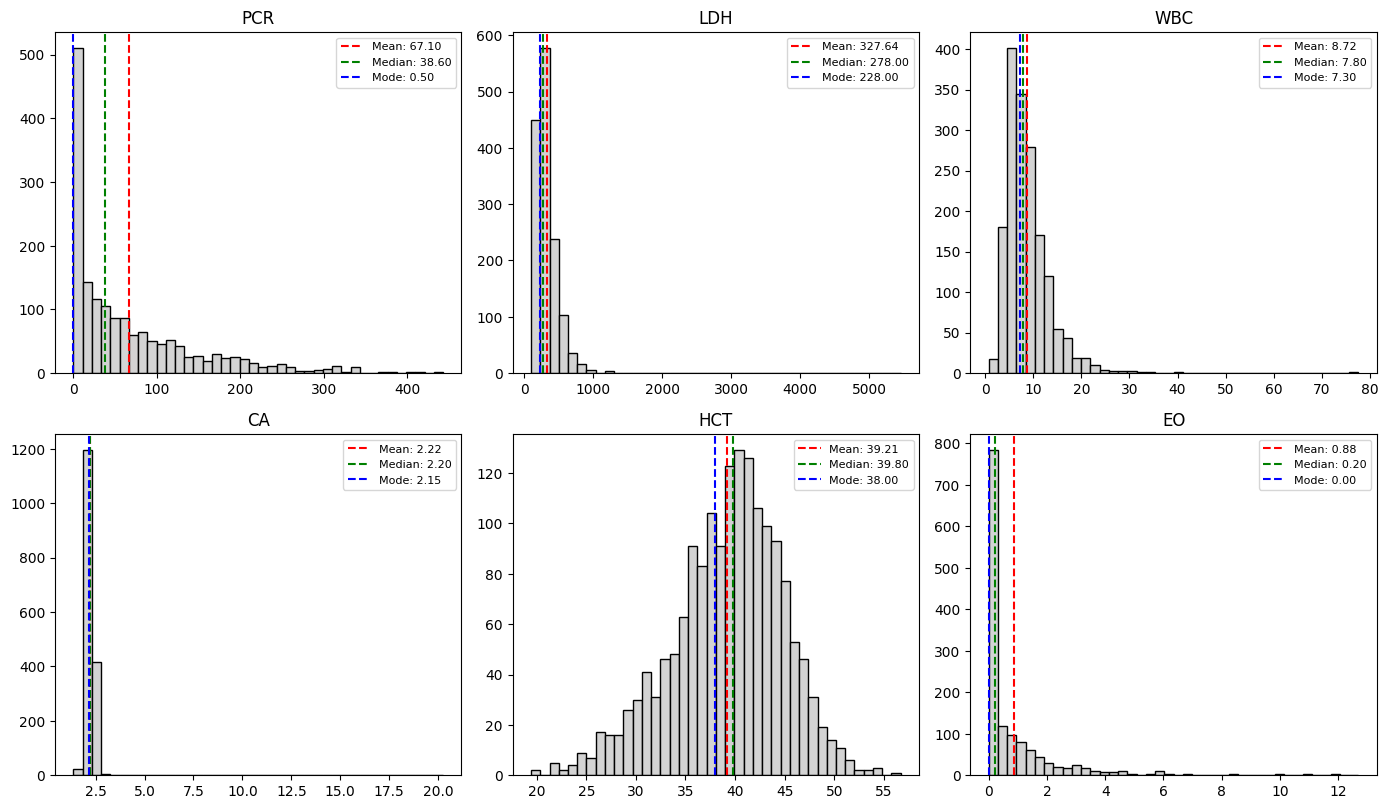

In [ ]:
variables = ['PCR', 'LDH', 'WBC', 'CA', 'HCT', 'EO']

plt.figure(figsize=(14, 16))

for i, var in enumerate(variables, 1):
    data = df[var].dropna()

    mean_val = data.mean()
    median_val = data.median()
    mode_val = data.mode()[0] if not data.mode().empty else np.nan

    plt.subplot(4, 3, i)
    plt.hist(data, bins=40, color='lightgrey', edgecolor='black')  # Gris claro y borde negro

    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='--', linewidth=1.5, label=f'Median: {median_val:.2f}')
    if not np.isnan(mode_val):
        plt.axvline(mode_val, color='blue', linestyle='--', linewidth=1.5, label=f'Mode: {mode_val:.2f}')

    plt.title(var)
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()


Visual analysis of the distributions reveals that most clinical parameters (PCR, LDH, WBC, and EO) exhibit positive skewness (right-skewed), indicating that the mean is displaced by the presence of extreme or critical values in the upper tail. In contrast, the CA variable shows a highly concentrated distribution around the mean with minimal dispersion, suggesting high stability in its levels. Finally, HCT presents a behavior close to a normal distribution, with a clear concordance between its mean, median, and mode, which facilitates its interpretation through parametric statistics.

##Bivariate Analysis: Feature Distribution per Target Class

###Boxplot

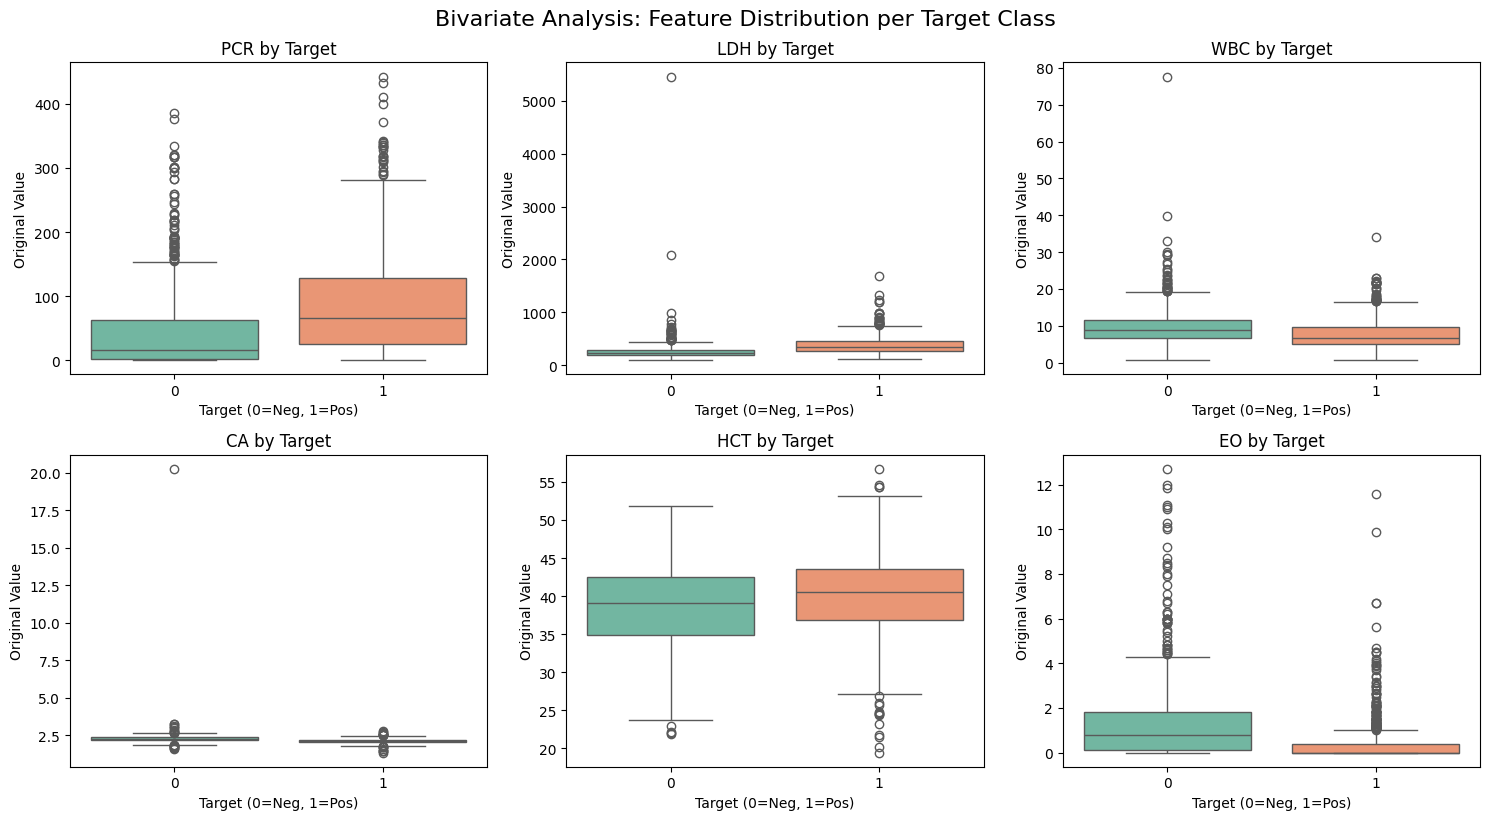

In [ ]:
import math

# 1. Filter numeric columns (excluding the target)
numeric_features = ['PCR', 'LDH', 'WBC', 'CA', 'HCT', 'EO']

# 2. Configure the grid layout
# We will plot 3 variables per row
cols_per_row = 3
num_rows = math.ceil(len(numeric_features) / cols_per_row)

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(15, num_rows * 4))
axes = axes.flatten() # Flatten the grid to iterate easily

# 3. Create a bivariate boxplot for each variable
for i, col in enumerate(numeric_features):
    sns.boxplot(ax=axes[i], x='target', y=col, hue='target', data=df, palette='Set2', legend=False)
    axes[i].set_title(f'{col} by Target', fontsize=12)
    axes[i].set_xlabel('Target (0=Neg, 1=Pos)')
    axes[i].set_ylabel('Original Value')

# 4. Remove empty subplots if the number of features isn't a multiple of 3
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Bivariate Analysis: Feature Distribution per Target Class', fontsize=16, y=1.02)
plt.show()

###Logaritmic Boxplot

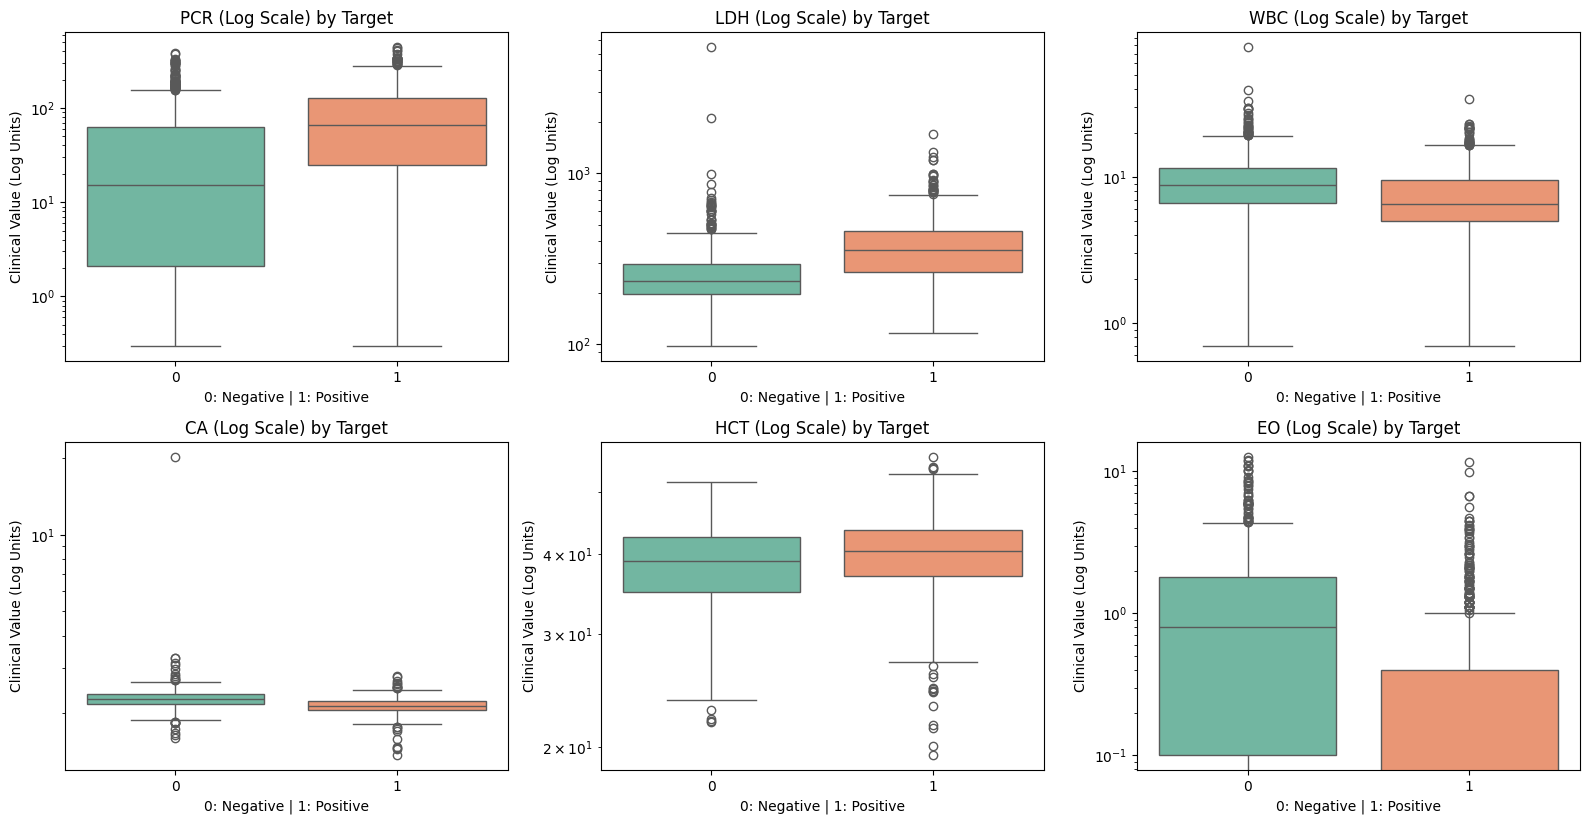

In [ ]:
target_vars = ['PCR', 'LDH', 'WBC', 'CA', 'HCT', 'EO']

plt.figure(figsize=(16, 12))
for i, var in enumerate(target_vars, 1):
    plt.subplot(3, 3, i)

    sns.boxplot(
        x='target',
        y=var,
        data=df,
        hue='target',
        palette='Set2',
        showfliers=True,
        legend=False
    )

    plt.yscale('log')

    plt.title(f'{var} (Log Scale) by Target', fontsize=12)
    plt.ylabel('Clinical Value (Log Units)')
    plt.xlabel('0: Negative | 1: Positive')

plt.tight_layout()
plt.show()

Comparative analysis using boxplots reveals significant differences in biomarker distributions based on patient status (Negative vs. Positive). Variables such as PCR and LDH show a notable increase in their median values for the positive group, suggesting strong discriminatory potential. In contrast, variables like WBC and EO exhibit an inverse trend or greater overlap between groups, indicating lower individual linear separation capacity. Notably, the persistent presence of outliers across all metrics (especially visible in the original scale) underscores the importance of employing logarithmic transformations to stabilize variance and enhance the visualization of interquartile differences.
To mitigate outliers influence during the training phase, a RobustScaler will be implemented. This ensures the model remains stable and prevents the decision boundaries from being skewed by extreme values.

#Data Cleaning & Wrangling

##Treating Missing Values

The CK and UREA columns have a high percentage of missing values (60% and 39%, respectively) and the missingness is not concentrated in any class. Therefore, we will drop both columns to maintain data quality.

In [ ]:
cols_to_drop = ['CK', 'UREA']

# Create the cleaned dataset for the next phase of EDA
df = df.drop(columns=cols_to_drop)

print(f"Feature pruning complete.")

Feature pruning complete.


In [ ]:

from sklearn.impute import KNNImputer
# Columns to impute using KNN (missing > 20%)
knn_cols = [
    'ALP', 'GGT', 'BA', 'NET', 'LYT', 'MOT', 'NE',
    'LY', 'BAT', 'EOT', 'MO', 'EO'
]

# Columns to impute using mean (missing 5-16%)
mean_cols = [
    'LDH', 'AST', 'GLU', 'PCR', 'ALT', 'CA', 'KAL', 'CREA',
    'NAT', 'HCT', 'HGB', 'RBC', 'WBC', 'MCV', 'MCH', 'MCHC',
    'PLT1', 'Age'
]

# Categorical columns to impute using mode
mode_cols = ['Sex']

# 1. KNN Imputer
# Filter knn_cols to only include columns actually in the DataFrame
knn_cols_existing = [col for col in knn_cols if col in df.columns]
if knn_cols_existing: # Only apply if there are columns to impute
    imputer = KNNImputer(n_neighbors=5)
    df[knn_cols_existing] = imputer.fit_transform(df[knn_cols_existing])

# 2. Impute missing values with mean
for col in mean_cols:
    if col in df.columns: # Ensure column exists
        df[col] = df[col].fillna(df[col].mean())

# 3. Impute categorical missing values with mode
for col in mode_cols:
    if col in df.columns: # Ensure column exists
        df[col] = df[col].fillna(df[col].mode()[0])

print(df.isna().sum())

Sex       0
Age       0
CA        0
CREA      0
ALP       0
GGT       0
GLU       0
AST       0
ALT       0
LDH       0
PCR       0
KAL       0
NAT       0
WBC       0
RBC       0
HGB       0
HCT       0
MCV       0
MCH       0
MCHC      0
PLT1      0
NE        0
LY        0
MO        0
EO        0
BA        0
NET       0
LYT       0
MOT       0
EOT       0
BAT       0
target    0
dtype: int64


###Variance Test

A variance test will be conducted to ensure that the imputation process maintains the original data distribution and sample representativeness.

In [ ]:
for col in mean_cols:
    if col in df_raw.columns and pd.api.types.is_object_dtype(df_raw[col]):
        df_raw[col] = df_raw[col].astype(str).str.replace(",", ".", regex=True)
        df_raw[col] = pd.to_numeric(df_raw[col], errors="coerce")
        df_raw[col] = df_raw[col].astype("float32")

for col in mean_cols:
    if col in df.columns:
        # Check if column is numeric before calculating std
        if pd.api.types.is_numeric_dtype(df_raw[col]):
            before = df_raw[col].std()
            after = df[col].std()
            print(f"{col} -> Before: {before:.2f}, After: {after:.2f}")
        else:
            print(f"Warning: Column '{col}' in df_raw is not numeric after conversion attempt. Skipping std calculation for df_raw.")

LDH -> Before: 211.62, After: 192.75
AST -> Before: 50.67, After: 49.35
GLU -> Before: 57.91, After: 56.40
PCR -> Before: 77.80, After: 75.79
ALT -> Before: 42.55, After: 41.46
CA -> Before: 0.48, After: 0.47
KAL -> Before: 0.52, After: 0.51
CREA -> Before: 0.98, After: 0.96
NAT -> Before: 4.58, After: 4.49
HCT -> Before: 5.61, After: 5.52
HGB -> Before: 2.04, After: 2.01
RBC -> Before: 0.73, After: 0.71
WBC -> Before: 4.64, After: 4.56
MCV -> Before: 7.06, After: 6.95
MCH -> Before: 2.72, After: 2.68
MCHC -> Before: 1.34, After: 1.32
PLT1 -> Before: 94.22, After: 92.73
Age -> Before: 19.55, After: 19.24


After the imputation, the standard deviation for all variables stayed very stable. This shows that we preserved the dataset's distribution without distorting the original biological signals. By choosing imputation instead of simply deleting rows with missing values, we kept the sample's integrity, allowing our models to use all available clinical information for more reliable predictions.

#Feature Selection & Pipeline Setup

##Correlation and Dependency Analysis
###Pearson & Spearman Correlation Matrix

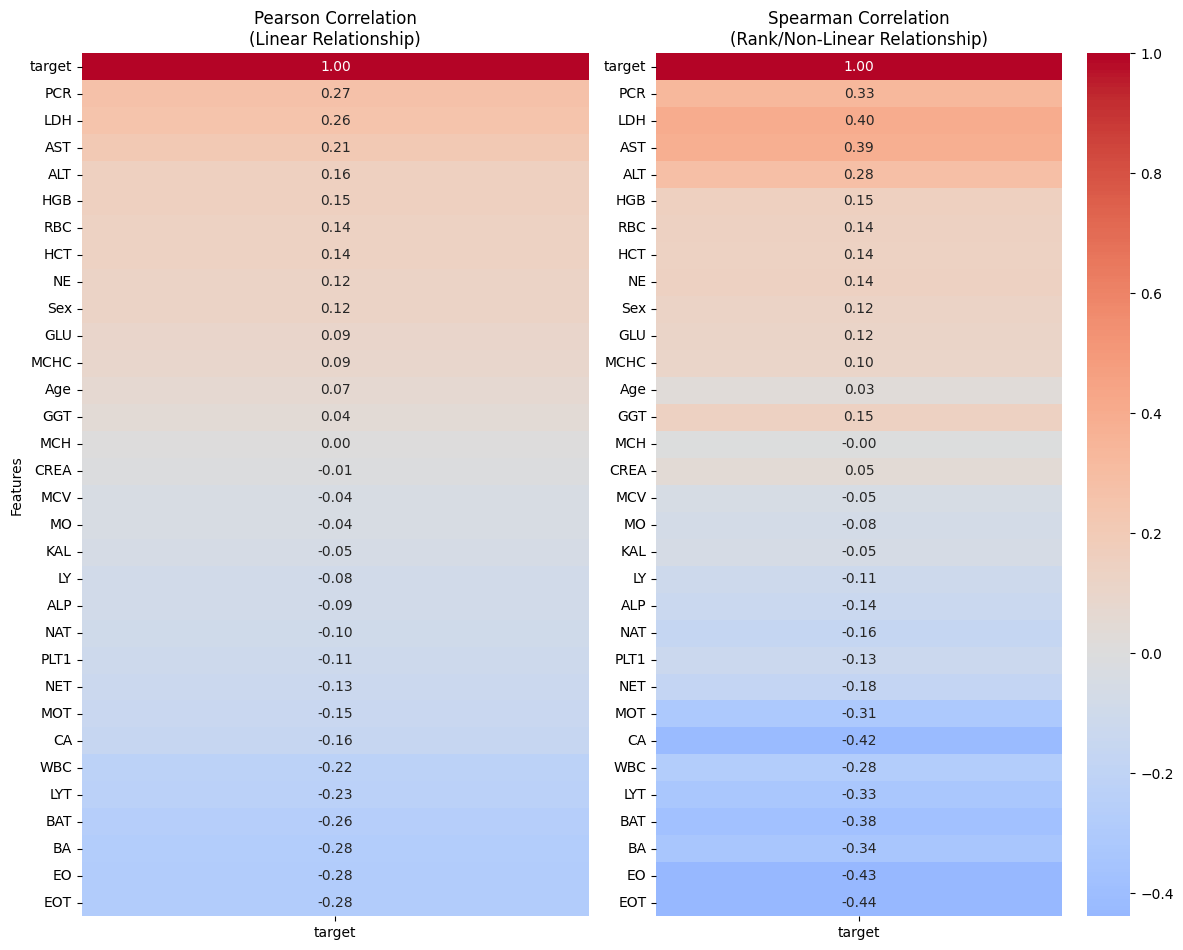

In [ ]:
# 1. Calculate both correlation methods
# We sort by Pearson to establish a baseline order
pearson_corr = df.corr(method='pearson')[['target']].sort_values(by='target', ascending=False)

# We use .reindex() to ensure Spearman follows the exact same feature order as Pearson
spearman_corr = df.corr(method='spearman')[['target']].reindex(pearson_corr.index)

# 2. Setup the figure with two subplots (1 row, 2 columns)
height = max(8, len(pearson_corr) * 0.3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, height))

# 3. Plot Pearson Heatmap
sns.heatmap(
    pearson_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    ax=ax1,
    cbar=False
)
ax1.set_title("Pearson Correlation\n(Linear Relationship)")
ax1.set_ylabel("Features")

# 4. Plot Spearman Heatmap
sns.heatmap(
    spearman_corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    ax=ax2
)
ax2.set_title("Spearman Correlation\n(Rank/Non-Linear Relationship)")
ax2.set_ylabel("") # Hide y-label for the second plot to save space

plt.tight_layout()
plt.show()

A comparison between Pearson and Spearman correlations shows that several key features, specifically EO, EOT, CA, and LDH, possess strong monotonic associations with the target that Pearson fails to fully capture. The increase from -0.28 to -0.44 in EO suggests a robust but curved relationship. Meanwhile, features like CREA, MCH, and Age consistently show near-zero scores across both metrics, their exclusion should be analyze to reduce model noise.

##Mutual Information Scores

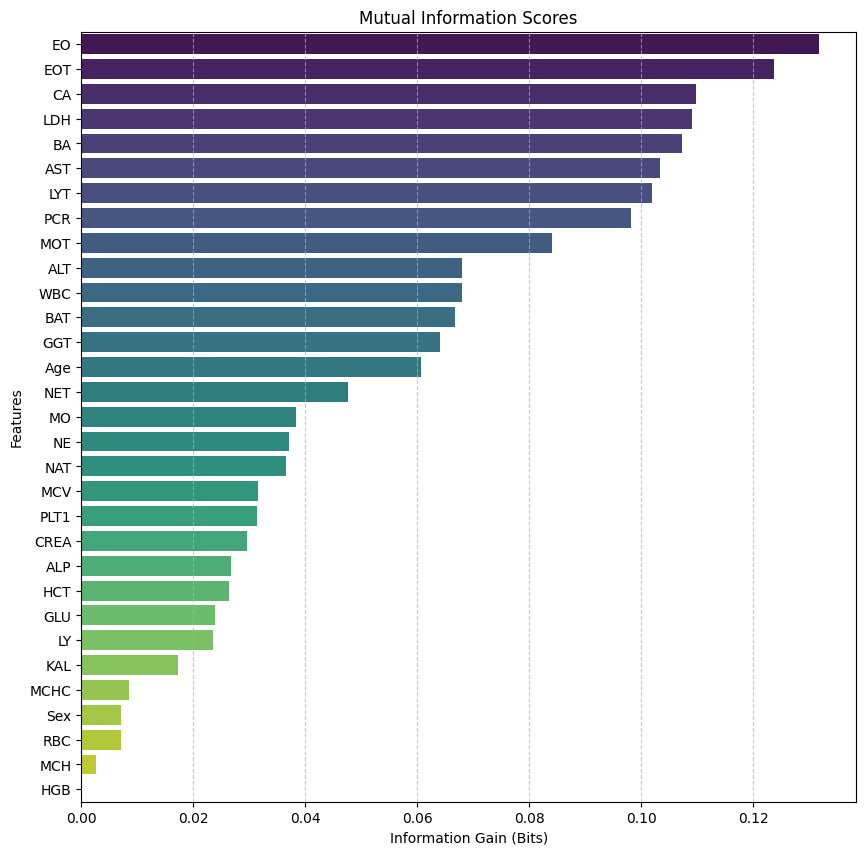

EO      0.131755
EOT     0.123744
CA      0.109746
LDH     0.109005
BA      0.107203
AST     0.103346
LYT     0.101924
PCR     0.098101
MOT     0.084035
ALT     0.068030
WBC     0.067907
BAT     0.066737
GGT     0.063977
Age     0.060686
NET     0.047612
MO      0.038263
NE      0.037044
NAT     0.036491
MCV     0.031635
PLT1    0.031341
CREA    0.029556
ALP     0.026774
HCT     0.026371
GLU     0.023906
LY      0.023552
KAL     0.017223
MCHC    0.008546
Sex     0.007104
RBC     0.007098
MCH     0.002607
HGB     0.000000
dtype: float64


In [ ]:
from sklearn.feature_selection import mutual_info_classif
X = df.drop(columns=['target'])
y = df['target']

X_mi = X.fillna(X.median())

discrete_features_mask = X_mi.dtypes != "float32"

mi_scores = mutual_info_classif(
    X_mi,
    y,
    discrete_features=discrete_features_mask,
    random_state=42
)

mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(
    x=mi_series.values,
    y=mi_series.index,
    hue=mi_series.index,
    palette='viridis',
    legend=False
)
plt.title("Mutual Information Scores")
plt.xlabel("Information Gain (Bits)")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(mi_series)

The Mutual Information analysis was performed to quantify the relationship between each clinical feature and the COVID-19 diagnosis. The results show that variables like EO, EOT, CA, and LDH provide the highest information gain. The declining trend in the scores indicates that a subset of top-ranking features contains most of the predictive power, allowing for a more efficient model by excluding variables with low contribution

###Correlation Between Variables

To eliminate duplicate information from variables measuring the same clinical phenomena at different scales, we verified their dependency using Pearson and Spearman correlations to detect linear and non-linear associations.

In [ ]:
from scipy.stats import pearsonr, spearmanr
print("----------Pearson Correlation----------")
corr, p_value = pearsonr(df['EO'], df['EOT'])

print("Correlation:", corr)
print("p-value:", p_value)
corr, p_value = spearmanr(df['EO'], df['EOT'])

print("----------Spearman Correlation----------")
print("Correlation:", corr)
print("p-value:", p_value)

----------Pearson Correlation----------
Correlation: 0.92453164
p-value: 0.0
----------Spearman Correlation----------
Correlation: 0.8945094210490186
p-value: 0.0


In [ ]:
print("----------Pearson Correlation----------")
corr, p_value = pearsonr(df['HCT'], df['RBC'])

print("Correlation:", corr)
print("p-value:", p_value)
corr, p_value = spearmanr(df['HCT'], df['RBC'])

print("----------Spearman Correlation----------")
print("Correlation:", corr)
print("p-value:", p_value)

----------Pearson Correlation----------
Correlation: 0.8574325
p-value: 0.0
----------Spearman Correlation----------
Correlation: 0.8511295355624775
p-value: 0.0


High correlation values, such as 0.92 for EO/EOT and 0.85 for HCT/RBC, confirmed the correlation between variables. Then, through triangulation by selecting the variable with the highest Mutual Information (MI) score, and ensuring that this choice was also supported by the clinical findings of the COVIDAL paper and the clinical argumentation we present, the following argued feature selection was defined.

###Feature Selection: Pathophysiological Framework

The final feature set is organized into four pillars to ensure a comprehensive clinical profile of the patient while maintaining model parsimony.

#### 1. Inflammation & Cell Death
* **Features:** `PCR`, `LDH`, `WBC`
* **Rationale:** Tracks the acute viral phase. `PCR` measures systemic inflammation, `LDH` signals tissue damage (cytolysis), and `WBC` quantifies total immune mobilization.

####2. Metabolic Stability
* **Feature:** `CA`
* **Rationale:** Represents electrolyte homeostasis. Critical for identifying metabolic decompensation and systemic stability during critical illness.

#### 3. Transport & Rheology
* **Feature:** `HCT`
* **Rationale:** Evaluates blood viscosity and oxygen transport capacity, which are determining factors in patient clinical evolution.

#### 4. Immune Regulation
* **Feature:** `EO`
* **Rationale:** eflects immune regulation. Eosinophil levels are altered in COVID-19 and have been associated with disease severity.

#Model Training

##Spliting Dataset

We split the data into training (80%) and testing (20%) sets.
'stratify=y' ensures the proportion of classes in the target is preserved across both sets.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Manually selecting features
selected_features = ['PCR', 'LDH', 'WBC', 'CA', 'HCT', 'EO']

X = df[selected_features]
y = df['target']

# Splitting

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Selected features for training: {selected_features}")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Selected features for training: ['PCR', 'LDH', 'WBC', 'CA', 'HCT', 'EO']
Training set size: 1381 samples
Test set size: 346 samples


In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 1. Preprocessor Definition
# RobustScaler is used to handle clinical outliers (e.g., extreme LDH or PCR values)
# by scaling features according to the quantile range.
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), selected_features)
    ],
    remainder='drop' # Ensures only selected top_features are passed to the model
)

# 2. Baseline Pipeline: Logistic Regression
# Used as a benchmark to justify the use of more complex non-linear models.
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# 3. Advanced Pipeline: XGBoost
# An ensemble gradient boosting model capable of capturing non-linear clinical patterns.
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# 4. Hyperparameter Search Space
# We explore different tree depths and learning rates to prevent overfitting
# and find the most generalizable model.
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.8, 1.0]
}

# 5. Grid Search Configuration
# Scoring set to 'roc_auc' to prioritize the model's ability to distinguish classes,
# which is critical in medical diagnostic contexts.
grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# 6. Training and Optimization
print("Training Baseline Logistic Regression...")
lr_pipeline.fit(X_train, y_train)

print("Starting Hyperparameter Optimization for XGBoost...")
grid_search.fit(X_train, y_train)

Training Baseline Logistic Regression...
Starting Hyperparameter Optimization for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:45:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         RobustScaler(),
                                                                         ['PCR',
                                                                          'LDH',
                                                                          'WBC',
                                                                          'CA',
                                                                          'HCT',
                                                                          'EO'])])),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categori...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.05, 0.1],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

#Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Función auxiliar para aplicar umbral
def get_preds_at_threshold(pipeline, X, threshold):
    return (pipeline.predict_proba(X)[:, 1] >= threshold).astype(int)

# 1. LOGISTIC REGRESSION
print("\n" + "="*55)
print("--- 1. LOGISTIC REGRESSION (Threshold 0.5) ---")
print(classification_report(y_test, lr_pipeline.predict(X_test)))

print("--- 2. LOGISTIC REGRESSION (Threshold 0.4) ---")
lr_preds_04 = get_preds_at_threshold(lr_pipeline, X_test, 0.4)
print(classification_report(y_test, lr_preds_04))
lr_auc = roc_auc_score(y_test, lr_pipeline.predict_proba(X_test)[:, 1])
print(f"Logistic Regression AUC: {lr_auc:.4f}")


# 2. XGBOOST
print("\n" + "="*55)
print(f"Best XGBoost CV AUC: {grid_search.best_score_:.4f}")
print(f"Optimized Params: {grid_search.best_params_}")

print("\n--- 3. XGBOOST (Threshold 0.5) ---")
best_xgb = grid_search.best_estimator_
print(classification_report(y_test, best_xgb.predict(X_test)))

print("--- 4. XGBOOST (Threshold 0.4) ---")
xgb_preds_04 = get_preds_at_threshold(best_xgb, X_test, 0.4)
print(classification_report(y_test, xgb_preds_04))
xgb_auc = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])
print(f"Optimized XGBoost AUC: {xgb_auc:.4f}")
print("="*55)


--- 1. LOGISTIC REGRESSION (Threshold 0.5) ---
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80       183
         1.0       0.79      0.75      0.77       163

    accuracy                           0.79       346
   macro avg       0.79      0.78      0.78       346
weighted avg       0.79      0.79      0.79       346

--- 2. LOGISTIC REGRESSION (Threshold 0.4) ---
              precision    recall  f1-score   support

         0.0       0.80      0.72      0.76       183
         1.0       0.72      0.80      0.76       163

    accuracy                           0.76       346
   macro avg       0.76      0.76      0.76       346
weighted avg       0.76      0.76      0.76       346

Logistic Regression AUC: 0.8376

Best XGBoost CV AUC: 0.8919
Optimized Params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}

--- 3. XGBOOST (Threshold 0.5) ---
         

## ROC Curve


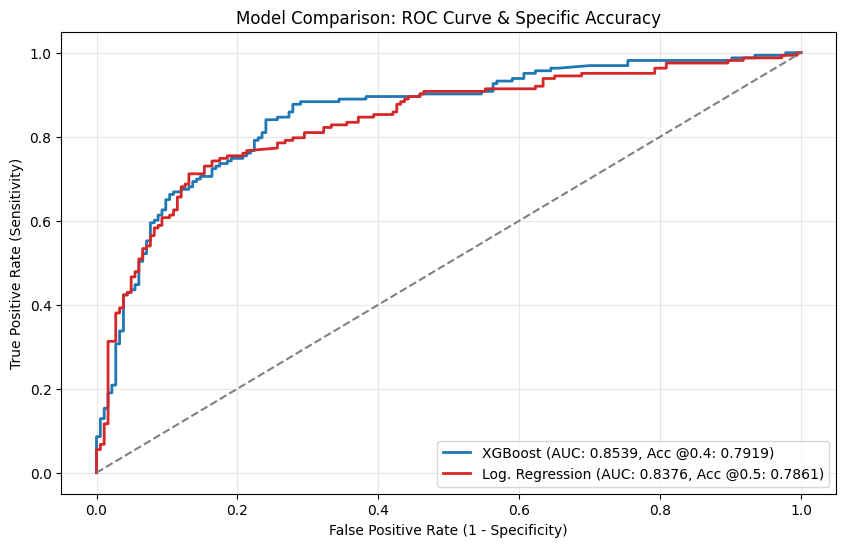

In [ ]:
from sklearn.metrics import roc_curve, accuracy_score

# --- 1. Use the predictions you already calculated ---
# We use the raw probabilities for the curves
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# We use the accuracy from the predictions you already made
# Log. Reg at 0.5 (lr_pipeline.predict) and XGBoost at 0.4 (xgb_preds_04)
acc_lr_05 = accuracy_score(y_test, lr_pipeline.predict(X_test))
acc_xgb_04 = accuracy_score(y_test, xgb_preds_04)

# --- 2. Calculate ROC curve points ---
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

# --- 3. Plotting ---
plt.figure(figsize=(10, 6))

# XGBoost Plot (using your 0.4 threshold results)
plt.plot(fpr_xgb, tpr_xgb, color='#1f77b4', lw=2,
         label=f'XGBoost (AUC: {xgb_auc:.4f}, Acc @0.4: {acc_xgb_04:.4f})')

# Logistic Regression Plot (using 0.5 threshold)
plt.plot(fpr_lr, tpr_lr, color='#d62728', lw=2,
         label=f'Log. Regression (AUC: {lr_auc:.4f}, Acc @0.5: {acc_lr_05:.4f})')

# Random Baseline
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Model Comparison: ROC Curve & Specific Accuracy')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

The ROC curve and accuracy metrics confirm that the Optimized XGBoost model is the superior choice for this clinical application. With an AUC of 0.8539, it provides better class separation than Logistic Regression (0.8376), meaning it is more effective at distinguishing between positive and negative cases across all possible thresholds. Specifically, when utilizing the clinical threshold of 0.4, XGBoost achieves a higher overall accuracy of 79.19% while simultaneously capturing more true positive cases, as seen in the previous confusion matrix. This combination of higher overall discriminative power (AUC) and better point-specific performance (Accuracy at 0.4) makes it a more reliable tool for patient risk assessment.

##SHAP Explanations: Logistic Regression vs. XGBoost
By applying SHAP to both models, we can compare them using a unified interpretability framework.

* **Logistic Regression SHAP:** Reveals a strictly linear relationship where feature impact is constant across all patients. This serves as our "Control Group" for interpretability.
* **XGBoost SHAP:** Reveals a more nuanced, non-linear distribution. The vertical dispersion of points for a single feature indicates **feature interactions**, meaning the risk of one biomarker depends on the values of others.


Generating SHAP Summary Plot for the Optimized XGBoost Model...


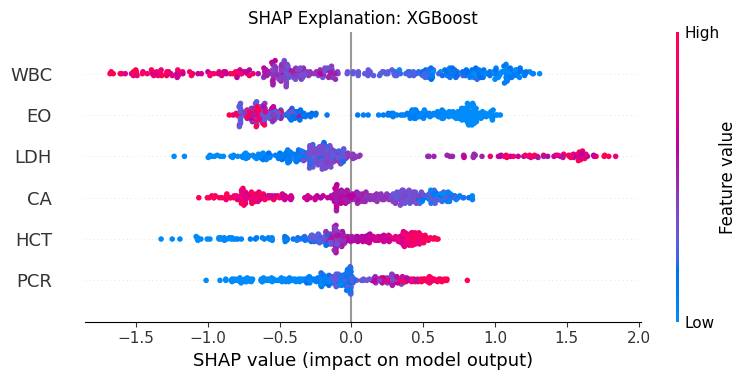

In [ ]:
import shap

# 1. Extract the optimized classifier and the preprocessor from the best pipeline
best_model = grid_search.best_estimator_
classifier = best_model.named_steps['classifier']
preprocessor = best_model.named_steps['preprocessor']

# 2. Transform the test data using the fitted scaler
# This ensures the SHAP explainer sees the same scaled values the model used
X_test_transformed = preprocessor.transform(X_test)

# 3. Initialize the SHAP Explainer
# We use shap.Explainer as it automatically selects the best algorithm (TreeSHAP)
explainer = shap.Explainer(classifier)
shap_values = explainer(X_test_transformed)

# 4. Generate the Summary Plot
# We pass feature_names so the Y-axis shows 'WBC', 'LDH', etc., instead of indices
print("Generating SHAP Summary Plot for the Optimized XGBoost Model...")
plt.title("SHAP Explanation: XGBoost")

shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=selected_features,
    plot_type="dot"
)

The SHAP summary plot ranks WBC count as the primary predictor, showing a consistent inverse relationship where lower values increase the model's output. LDH and PCR follow as key indicators with a direct impact on the prediction; however, the LDH distribution suggests a non-linear effect, as the risk increases sharply only at exceptionally high values.

Similarly, elevated HCT levels are associated with positive SHAP values. For CA, the model identifies a general trend where lower levels contribute to a positive diagnosis, though the overlapping data points near the center indicate that its influence may be subject to complex interactions with other clinical variables."

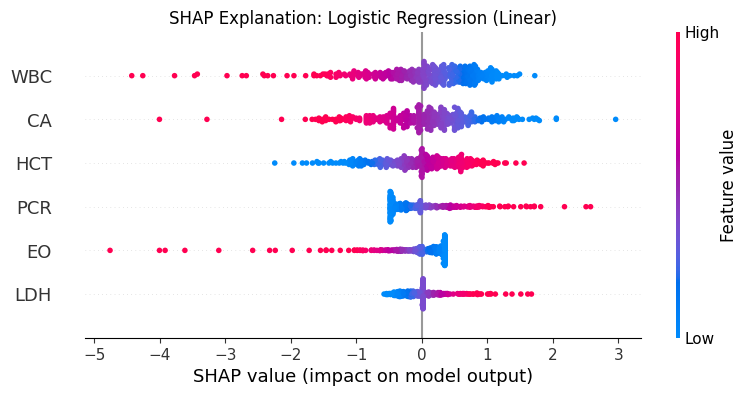

In [ ]:
# 1. Get the model from your pipeline
lr_model = lr_pipeline.named_steps['classifier']
# 2. Get the transformed data
X_test_lr = lr_pipeline.named_steps['preprocessor'].transform(X_test)

# 3. Calculate SHAP values (using the background distribution)
explainer_lr = shap.LinearExplainer(lr_model, X_test_lr)
shap_values_lr = explainer_lr.shap_values(X_test_lr)

# 4. Plot
plt.figure()
shap.summary_plot(shap_values_lr, X_test_lr,
                  feature_names= ['PCR', 'LDH', 'WBC', 'CA', 'HCT', 'EO'],
                  show=False)
plt.title("SHAP Explanation: Logistic Regression (Linear)")
plt.show()

The SHAP summary plot reflects the monotonic nature of the Logistic Regression model, where each feature has a fixed directional impact. WBC is the most significant predictor, showing a strict inverse relationship where lower values (blue) increase the probability of a positive outcome.

Similarly, HCT, PCR, and LDH exhibit positive coefficients, meaning higher values (red) consistently drive the model toward a positive prediction. Conversely, CA and EO act as negative predictors; notably, high EO levels (red) provide a strong inhibitory effect, significantly reducing the likelihood of a positive diagnosis

## Confusion Matrix

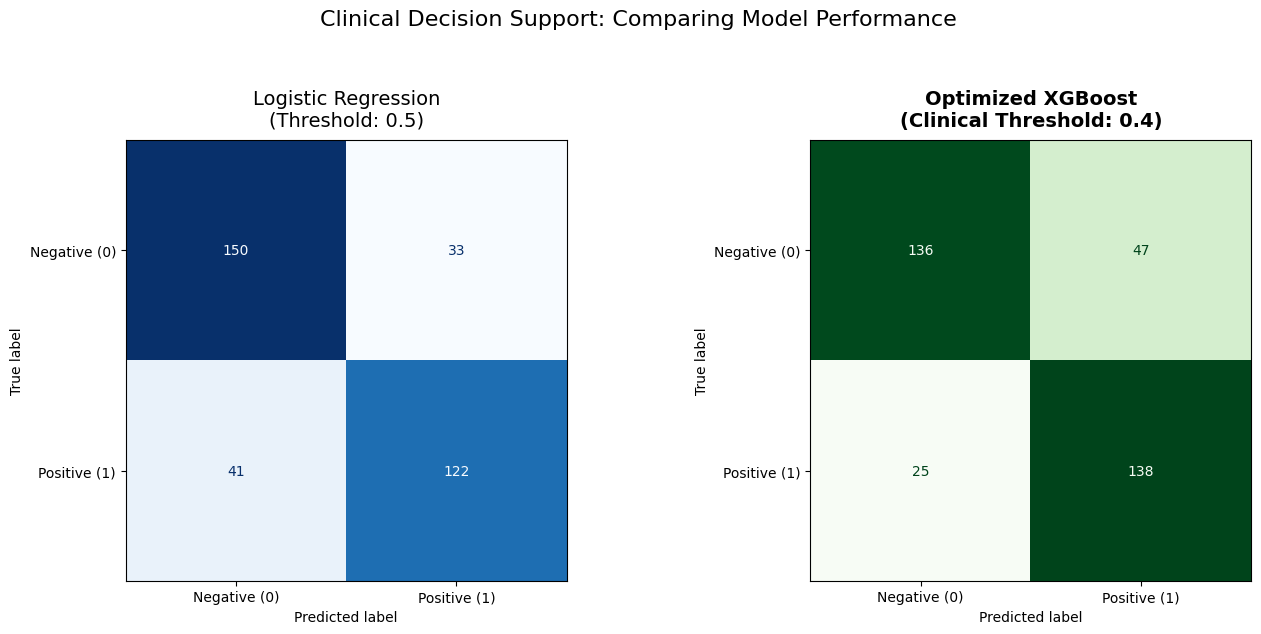

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Generate predictions with the specific thresholds you chose
# Logistic Regression stays at 0.5 (default .predict uses 0.5)
lr_final_preds = lr_pipeline.predict(X_test)

# XGBoost uses your optimized 0.4 clinical threshold
xgb_final_preds_04 = get_preds_at_threshold(best_xgb, X_test, 0.4)

# 2. Create the figure for comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Logistic Regression (Standard 0.5) ---
cm_lr = confusion_matrix(y_test, lr_final_preds)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['Negative (0)', 'Positive (1)'])
disp_lr.plot(ax=ax[0], cmap='Blues', colorbar=False)
ax[0].set_title('Logistic Regression\n(Threshold: 0.5)', fontsize=14, pad=10)

# --- Plot 2: Optimized XGBoost (Clinical 0.4) ---
cm_xgb = confusion_matrix(y_test, xgb_final_preds_04)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Negative (0)', 'Positive (1)'])
disp_xgb.plot(ax=ax[1], cmap='Greens', colorbar=False)
ax[1].set_title('Optimized XGBoost\n(Clinical Threshold: 0.4)', fontsize=14, pad=10, fontweight='bold')

# Add a general title to explain the clinical relevance
plt.suptitle('Clinical Decision Support: Comparing Model Performance', fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

By lowering the classification threshold to 0.4, the Optimized XGBoost model prioritizes Recall (Sensitivity) over the standard 0.5 Logistic Regression baseline, which is a critical trade-off in clinical decision-making. While the Logistic Regression model maintains higher specificity with fewer False Positives (33 vs. 47), the XGBoost model significantly reduces dangerous False Negatives from 41 to 25. This adjustment ensures that more actual positive cases are captured, identifying 138 patients compared to 122, minimizing the clinical risk of missing a diagnosis at the acceptable cost of a slightly higher rate of false alarms.